In [1]:
import multiprocessing as mp
import platform

if platform.system() != "Windows":
    mp.set_start_method('forkserver')

import pandas as pd

from tb_incubator.constants import set_project_base_path
from tb_incubator.input import load_targets, load_param_info
from tb_incubator.calibrate import get_bcm

from estival.wrappers import pymc as epm
import pymc as pm

import arviz as az
from estival.sampling.tools import likelihood_extras_for_idata
from estival.utils.parallel import map_parallel

#pd.options.plotting.backend = "plotly"  
project_paths = set_project_base_path("../tb_incubator/")


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
params= load_param_info()["value"]
all_targets = load_targets()

In [3]:
bcm = get_bcm(params)

In [4]:
with pm.Model() as model:
    variables = epm.use_model(bcm)
    idata = pm.sample(step=[pm.DEMetropolis(variables)], draws=2000, tune=2000,cores=16,chains=16)

Population sampling (16 chains)
DEMetropolis: [contact_rate, self_recovery_rate, screening_scaleup_shape, screening_inflection_time, time_to_screening_end_asymp, rr_infection_latent, rr_infection_recovered, seed_time, base_sensitivity, genexpert_sensitivity, progression_multiplier, prevalence_dispersion, notification_dispersion]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.

Sampling 16 chains for 2_000 tune and 2_000 draw iterations (32_000 + 32_000 draws total) took 142 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [5]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
contact_rate,8.584,1.148,6.329,9.947,0.191,0.136,36.0,49.0,1.38
self_recovery_rate,0.290,0.105,0.126,0.492,0.019,0.014,30.0,21.0,1.50
screening_scaleup_shape,0.224,0.122,0.023,0.436,0.016,0.012,58.0,138.0,1.19
screening_inflection_time,2006.396,3.339,2001.652,2013.076,0.505,0.359,46.0,80.0,1.27
time_to_screening_end_asymp,3.675,2.084,0.341,6.987,0.302,0.215,39.0,24.0,1.34
rr_infection_latent,0.485,0.272,0.087,0.935,0.048,0.037,34.0,48.0,1.43
rr_infection_recovered,0.508,0.245,0.090,0.936,0.029,0.021,68.0,106.0,1.17
seed_time,1873.283,16.961,1846.862,1899.864,2.453,1.748,42.0,28.0,1.31
base_sensitivity,0.696,0.202,0.314,0.982,0.032,0.023,37.0,25.0,1.37
genexpert_sensitivity,0.520,0.258,0.099,0.970,0.030,0.021,71.0,97.0,1.19


array([[<Axes: title={'center': 'contact_rate'}>,
        <Axes: title={'center': 'contact_rate'}>],
       [<Axes: title={'center': 'self_recovery_rate'}>,
        <Axes: title={'center': 'self_recovery_rate'}>],
       [<Axes: title={'center': 'screening_scaleup_shape'}>,
        <Axes: title={'center': 'screening_scaleup_shape'}>],
       [<Axes: title={'center': 'screening_inflection_time'}>,
        <Axes: title={'center': 'screening_inflection_time'}>],
       [<Axes: title={'center': 'time_to_screening_end_asymp'}>,
        <Axes: title={'center': 'time_to_screening_end_asymp'}>],
       [<Axes: title={'center': 'rr_infection_latent'}>,
        <Axes: title={'center': 'rr_infection_latent'}>],
       [<Axes: title={'center': 'rr_infection_recovered'}>,
        <Axes: title={'center': 'rr_infection_recovered'}>],
       [<Axes: title={'center': 'seed_time'}>,
        <Axes: title={'center': 'seed_time'}>],
       [<Axes: title={'center': 'base_sensitivity'}>,
        <Axes: title

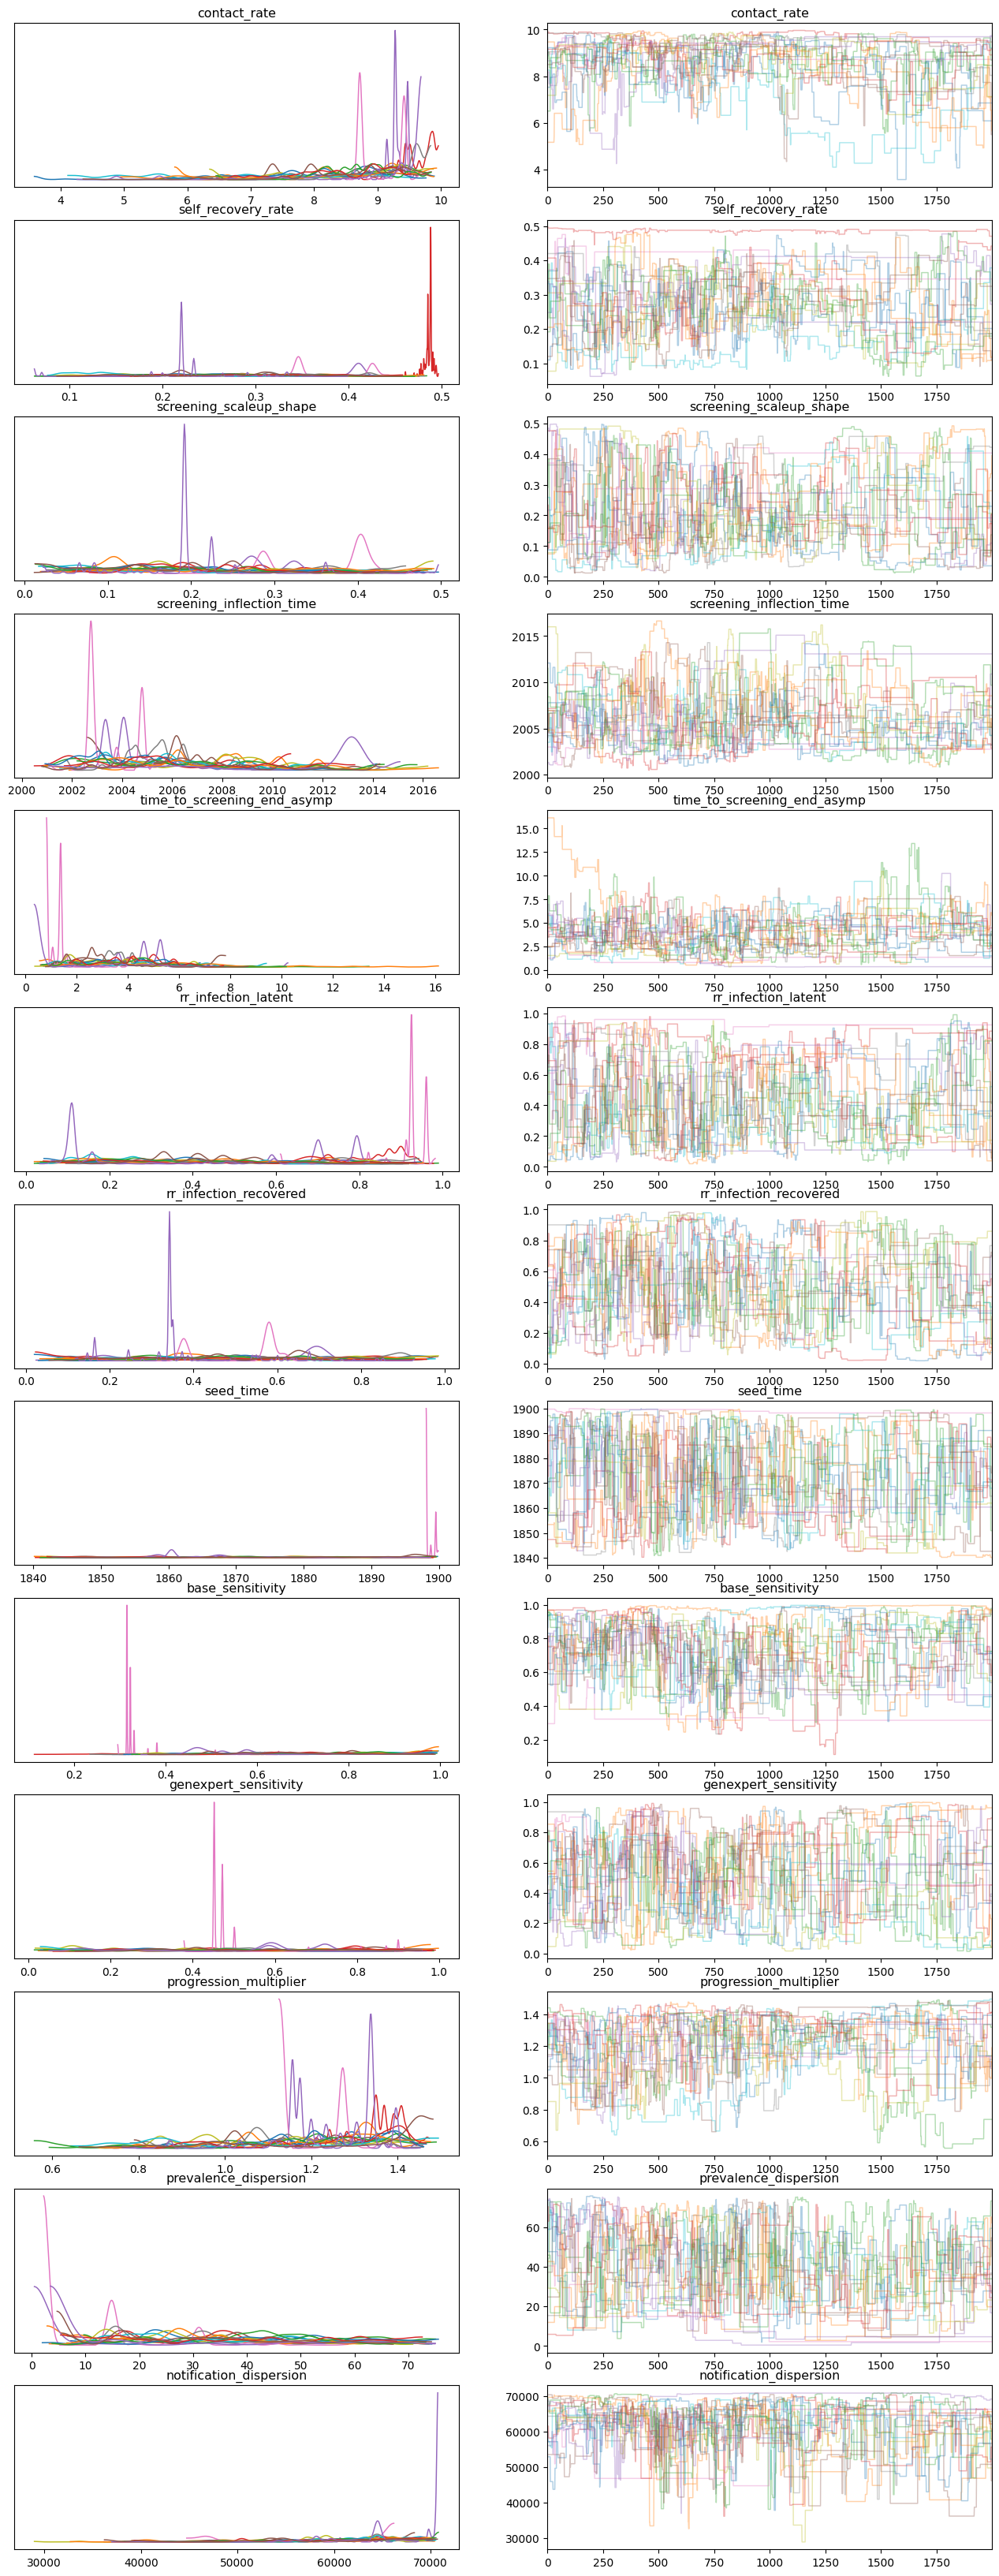

In [6]:
az.plot_trace(idata, figsize=(16,3.2*len(idata.posterior)),compact=False)

array([[<Axes: title={'center': 'contact_rate'}>,
        <Axes: title={'center': 'self_recovery_rate'}>,
        <Axes: title={'center': 'screening_scaleup_shape'}>,
        <Axes: title={'center': 'screening_inflection_time'}>],
       [<Axes: title={'center': 'time_to_screening_end_asymp'}>,
        <Axes: title={'center': 'rr_infection_latent'}>,
        <Axes: title={'center': 'rr_infection_recovered'}>,
        <Axes: title={'center': 'seed_time'}>],
       [<Axes: title={'center': 'base_sensitivity'}>,
        <Axes: title={'center': 'genexpert_sensitivity'}>,
        <Axes: title={'center': 'progression_multiplier'}>,
        <Axes: title={'center': 'prevalence_dispersion'}>],
       [<Axes: title={'center': 'notification_dispersion'}>, <Axes: >,
        <Axes: >, <Axes: >]], dtype=object)

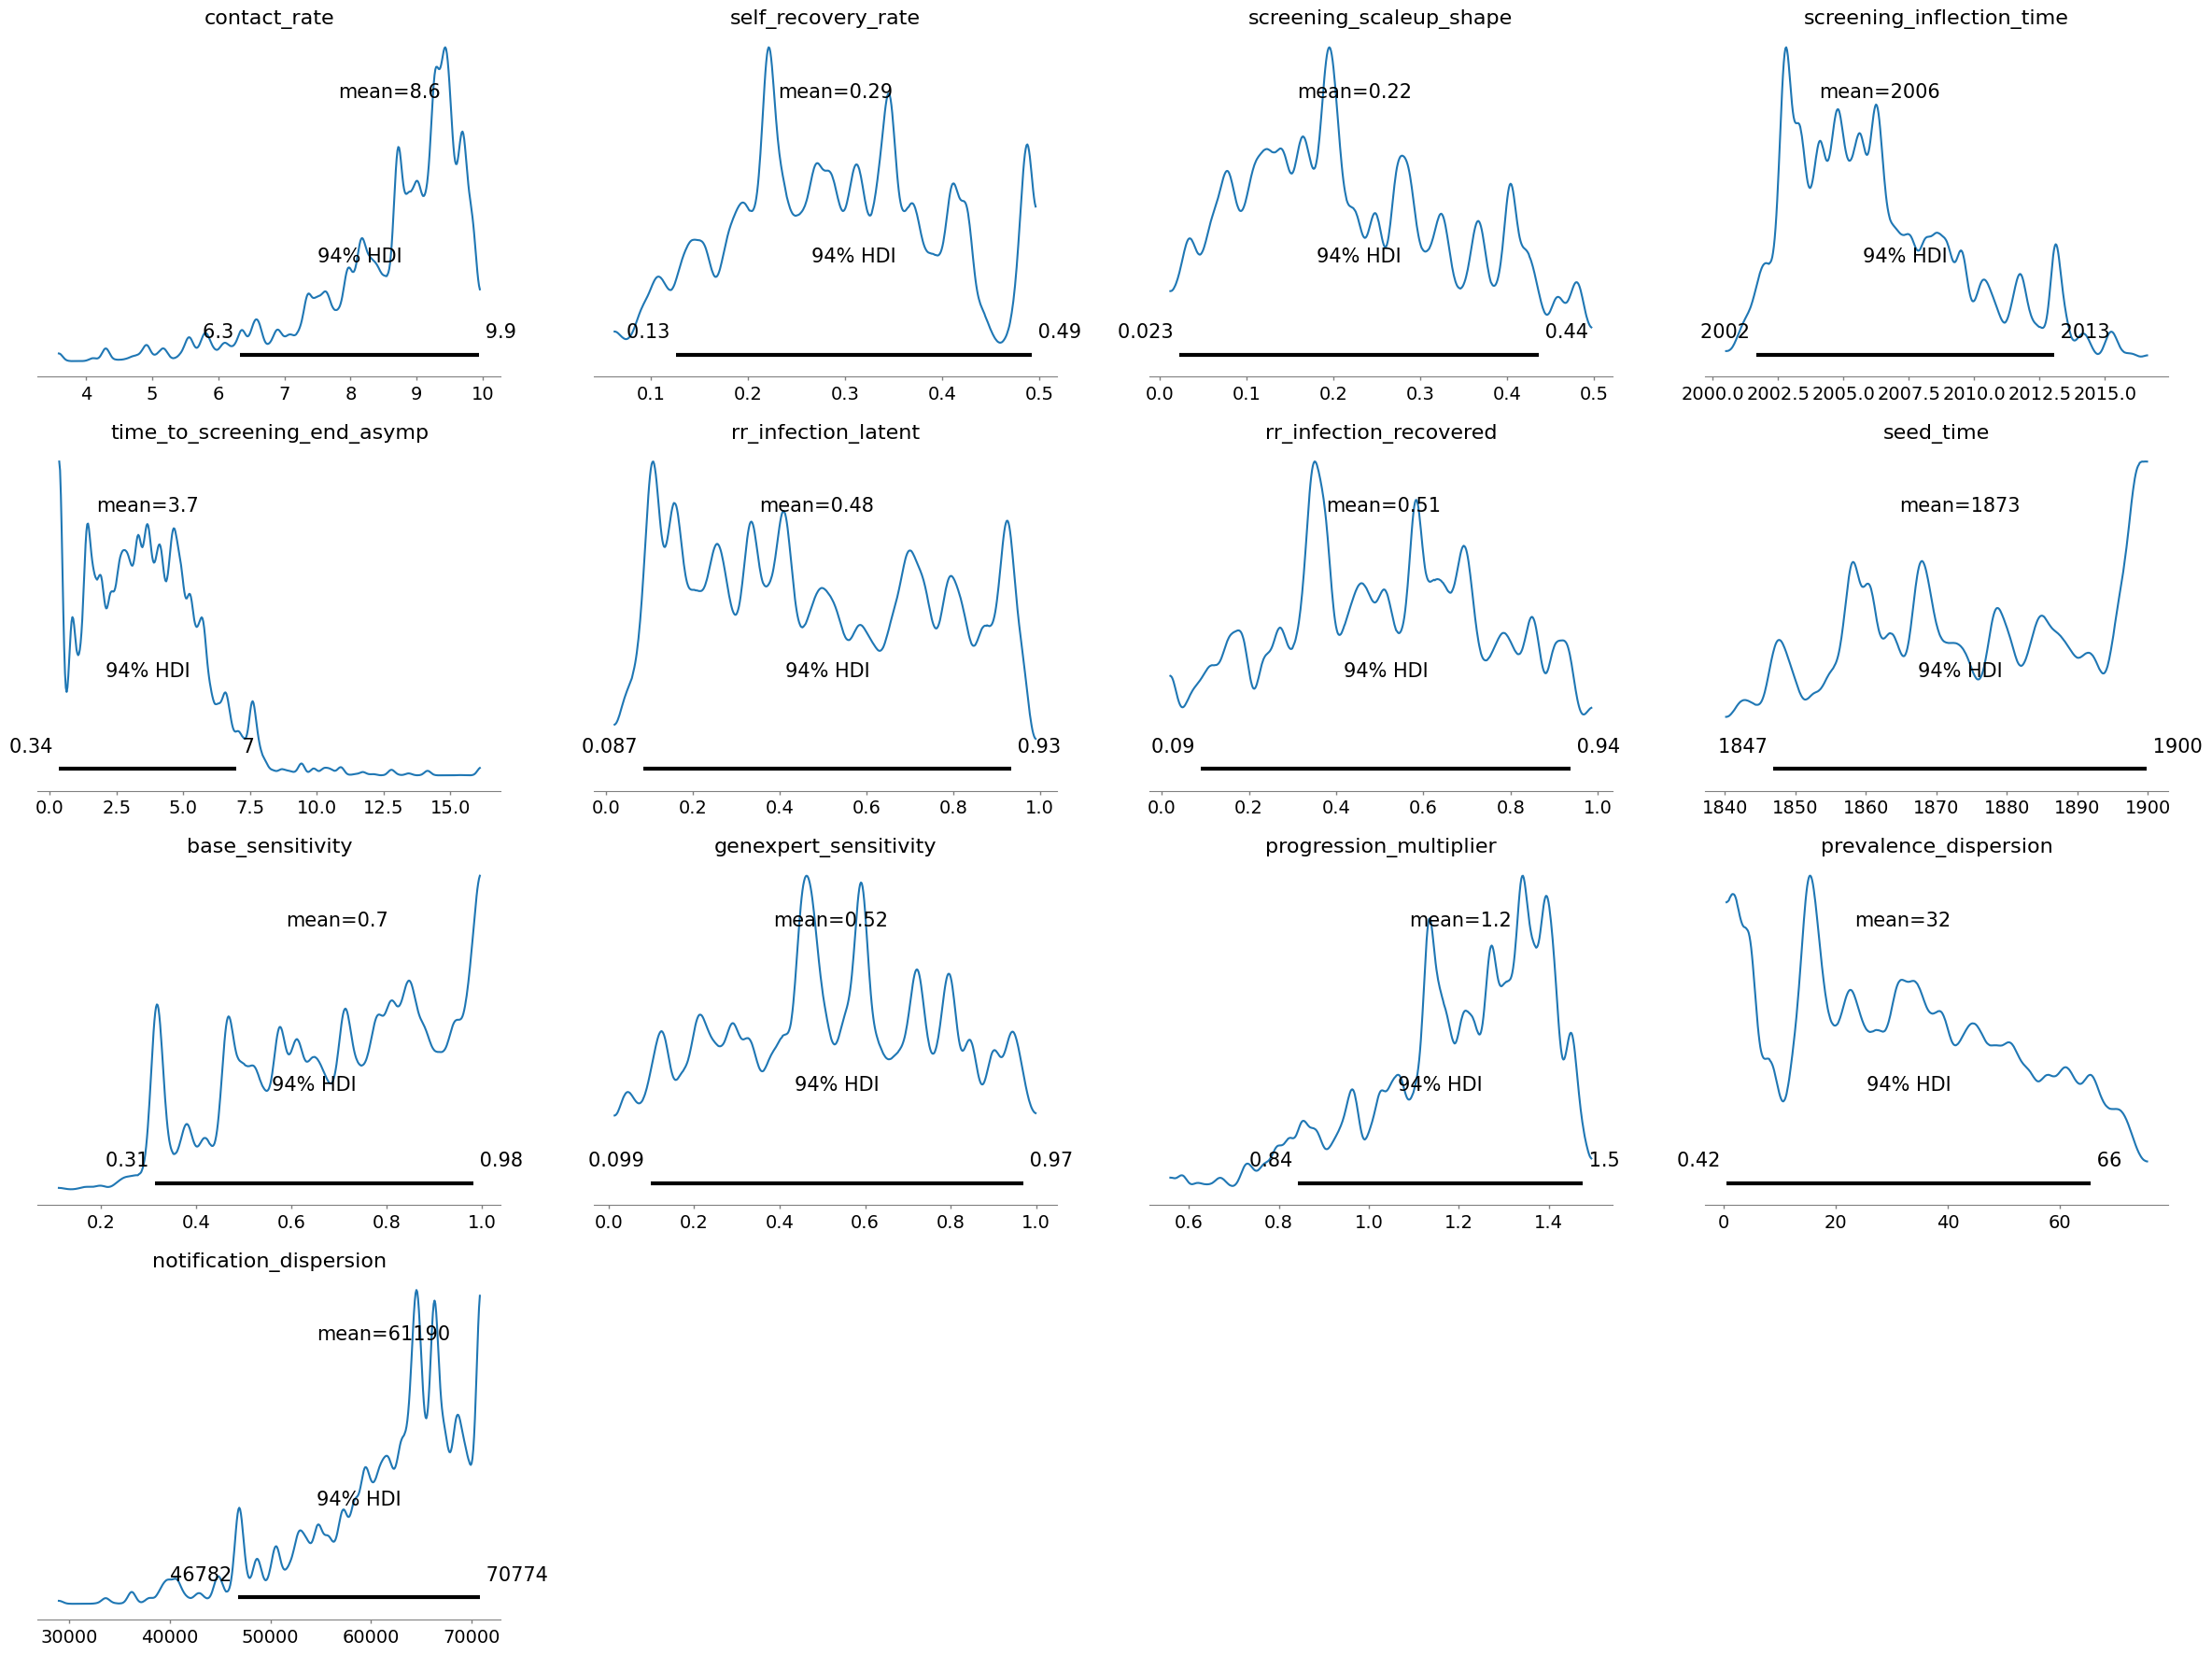

In [7]:
az.plot_posterior(idata)

In [8]:
likelihood_df = likelihood_extras_for_idata(idata, bcm)
likelihood_df

logposterior   logprior  loglikelihood  ll_notification  \
chain draw                                                            
0     0       -47.674617 -26.212684     -21.461933       -16.119264   
      1       -47.674617 -26.212684     -21.461933       -16.119264   
      2       -47.674617 -26.212684     -21.461933       -16.119264   
      3       -46.004586 -26.212684     -19.791902       -14.558434   
      4       -46.004586 -26.212684     -19.791902       -14.558434   
...                  ...        ...            ...              ...   
15    1995    -45.041889 -26.212684     -18.829205       -14.274496   
      1996    -45.041889 -26.212684     -18.829205       -14.274496   
      1997    -45.041889 -26.212684     -18.829205       -14.274496   
      1998    -45.041889 -26.212684     -18.829205       -14.274496   
      1999    -45.041889 -26.212684     -18.829205       -14.274496   

            ll_prevalence  
chain draw                 
0     0         -5.342669  
      1         -5.342669  
      2         -5.342669  
      3         -5.233468  
      4         -5.233468  
...                   ...  
15    1995      -4.554709  
      1996      -4.554709  
      1997      -4.554709  
      1998      -4.554709  
      1999      -4.554709  

[32000 rows x 5 columns]

<Axes: xlabel='draw'>

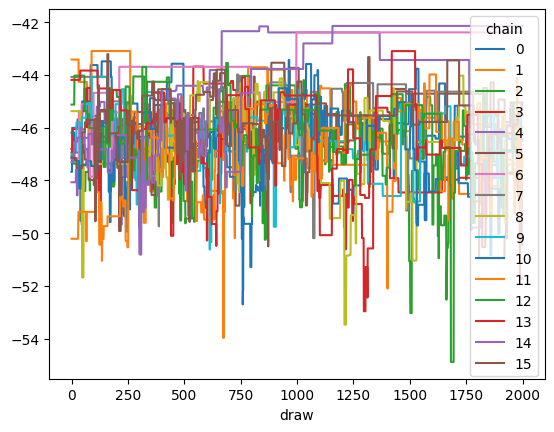

In [9]:
# Examine the performance of chains over time
ldf_pivot = likelihood_df.reset_index(level="chain").pivot(columns=["chain"])
ldf_pivot["logposterior"].plot()

In [10]:
ldf_sorted = likelihood_df.sort_values(by="logposterior",ascending=False)
map_params = idata.posterior.to_dataframe().loc[ldf_sorted.index[0]].to_dict()

map_params

{'contact_rate': 9.693581644169758,
 'self_recovery_rate': 0.22029328502351625,
 'screening_scaleup_shape': 0.19209322481403163,
 'screening_inflection_time': 2013.0734788806612,
 'time_to_screening_end_asymp': 0.3712285639091873,
 'rr_infection_latent': 0.10924722155060007,
 'rr_infection_recovered': 0.34214309875590565,
 'seed_time': 1860.365171658641,
 'base_sensitivity': 0.4658220837507234,
 'genexpert_sensitivity': 0.592652351325375,
 'progression_multiplier': 1.3372029327851038,
 'prevalence_dispersion': 4.619415352948195,
 'notification_dispersion': 64507.70610176572}

In [11]:
bcm.loglikelihood(**map_params), ldf_sorted.iloc[0]["loglikelihood"]

(Array(-15.92578909, dtype=float64), -15.925789087499055)

In [12]:
map_res = bcm.run(map_params)

<Axes: title={'center': 'prevalence (MLE)'}>

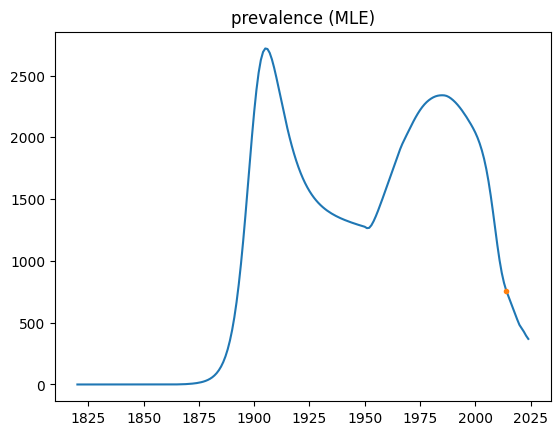

In [13]:
variable = "prevalence"

pd.Series(map_res.derived_outputs[variable]).plot(title = f"{variable} (MLE)")
bcm.targets[variable].data.plot(style='.')

<Axes: title={'center': 'notification (MLE)'}>

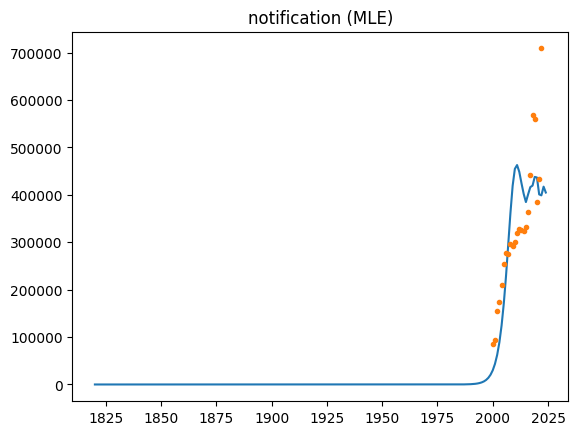

In [14]:
variable = "notification"

pd.Series(map_res.derived_outputs[variable]).plot(title = f"{variable} (MLE)")
bcm.targets[variable].data.plot(style='.')